# Notebook 02 - Distributions

*Martin Vonk - 2022*

This notebooks shows an example of choosing the right distribution of the precipitation or precipitation-excess. Note that this notebooks focusses on visually interpreting this data. There are also tests to check the validity of a distribution. However these are not currently implemented in this package.

## Required packages

In [15]:
from calendar import month_name
from typing import Literal

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
from matplotlib import patheffects
from scipy.stats._survival import EmpiricalDistributionFunction

import spei as si  # si for standardized index

print(si.show_versions())

python: 3.13.1
spei: 0.7.0
numpy: 2.2.4
scipy: 1.15.2
matplotlib: 3.10.1
pandas: 2.2.3


In [31]:
sps.norm.cdf(-1.0)

np.float64(0.15865525393145707)

In [2]:
def plot_ecdf(
    ax: plt.Axes,
    data: pd.Series,
    ecdf: EmpiricalDistributionFunction,
    s: float,
    color: str,
    label: str,
    cdf: pd.Series | None = None,
    **kwargs,
) -> None:
    data = data.drop_duplicates()
    ax.scatter(
        data,
        ecdf.probabilities,
        s=s,
        facecolor=color,
        label=label,
        **kwargs,
    )
    if cdf is not None:
        for idata, icdf, iecdf in zip(data, cdf, ecdf.probabilities):
            ax.plot(
                [idata, idata],
                [iecdf, icdf],
                color=color,
                linewidth=0.5,
                **kwargs,
            )
    return ecdf


def axes_indicator(
    ax: plt.Axes,
    letter: str,
    x: float,
    y: float,
    ha: Literal["left", "right"],
    va: Literal["top", "bottom"],
):
    """Add an indicator to the axes."""
    ax.annotate(
        f"({letter})",
        xy=(x, y),
        xycoords="axes fraction",
        fontsize=mpl.rcParams["axes.titlesize"],
        horizontalalignment=ha,
        verticalalignment=va,
        path_effects=[
            patheffects.Stroke(linewidth=1, foreground="white"),
            patheffects.Normal(),
        ],
    )

## Load time series

We use time series from the Netherlands. The precipitation and precipitation-excess (precipitation - potential evaporation) time series are accumulated on with a 30D rolling sum.

<Axes: title={'center': 'Precipitation Excess'}, ylabel='[mm]'>

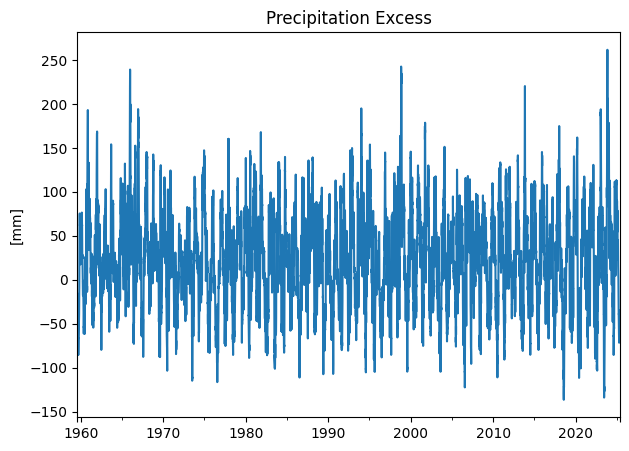

In [3]:
df = pd.read_csv("data/B32C0572_DEBILT.csv", index_col=0, parse_dates=True)
rain = df["Prec [m/d] 260_DEBILT"].multiply(1e3).rename("prec")
evap = df["Evap [m/d] 260_DEBILT"].multiply(1e3).rename("evap")

# accumulate time series
f = 30
prec = rain.rolling(f"{f}D", min_periods=f).sum().dropna()
surplusd = rain - evap
pe = surplusd.dropna().rolling(f"{f}D", min_periods=f).sum().dropna()
pe.plot(xlabel="", ylabel="[mm]", title="Precipitation Excess", figsize=(7, 5))

## Plot distributions

The internal plot.dist method can be used to plot the (cumulative) histogram and the scipy.stats distribution fit. The given distribution using a [maximum likelihood estimate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html#scipy.stats.rv_continuous.fit) where a negative log-likelihood function is minimized. It can be important to visually check if the (cumulative) density function is actually valid for the (cumulative) histogram of the data. Let's first try that for the log-logistic (fisk) distribution. 

We'll reproduce some steps that are normally done internally. Therefor we need to create the SI class and fit the distribution.

In [4]:
spei_fisk = si.SI(pe, dist=sps.fisk, fit_freq="ME")
spei_fisk.fit_distribution()

Lets fit the log-logistic (fisk) distribution

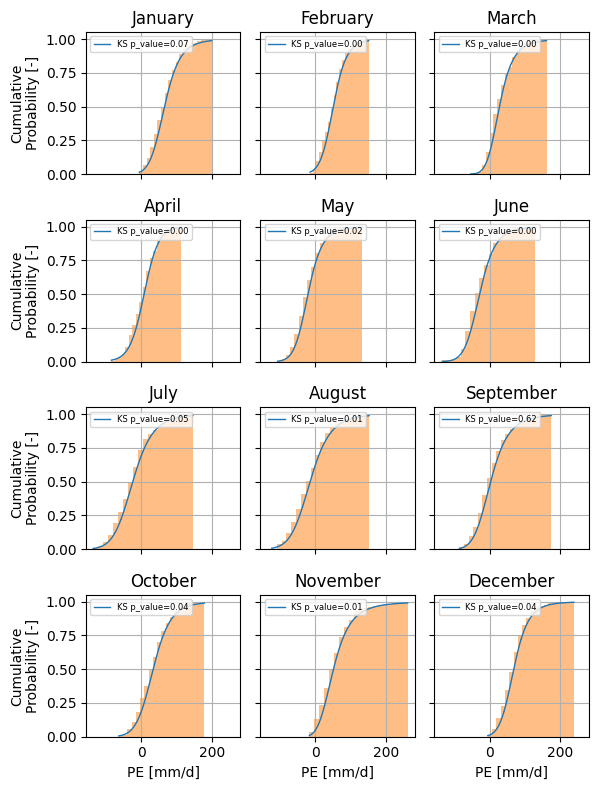

In [5]:
f, axl = plt.subplots(4, 3, figsize=(6, 8), sharey=True, sharex=True)
axsr = axl.ravel()
for date, dist in spei_fisk._dist_dict.items():
    cdf = dist.cdf().sort_values()
    p_value = dist.ks_test()
    i = date.month - 1
    axsr[i].plot(
        dist.data.loc[cdf.index].values,
        cdf.values,
        color="C0",
        linewidth=1,
        label=f"KS {p_value=:0.2f}",
    )
    axsr[i].hist(
        dist.data.values,
        alpha=0.5,
        density=True,
        cumulative=True,
        bins=20,
        color="C1",
    )
    axsr[i].set_title(month_name[date.month])
    axsr[i].grid(True)
    axsr[i].legend(loc=2, fontsize=6)

[ax.set_ylabel("Cumulative\nProbability [-]") for ax in axl[:, 0]]
[ax.set_xlabel("PE [mm/d]") for ax in axl[-1, :]]
f.tight_layout()

The blue plotted line is the fitted log-logistic (fisk) distribution and the orange fill is the cumulative histogram. For the fitted distributions seem to describe the precipitation excess values pretty well. The legend shows the p_value of the two-sided        Kolmogorov-Smirnov test for goodness of fit. The null hypothesis two-sided test is that the two distributions are identical, the alternative is that they are not identical. Say we choose a confidence level of 95%; that is, we will reject the null hypothesis in favor of the alternative if the p-value is less than 0.05. For e.g. march the p-value is lower than our threshold of 0.05, so we reject the null hypothesis in favor of the default “two-sided” alternative: the data are not distributed according to the fitted pearson3 distribution. But not finding the appropriate distribution is one of the big uncertainties of the standardized index method. However, not a perfect fit does not mean this distribution is not fit-for-purpose of calculating a drought index. That is up to the modeller to decide. 

We could try to fit another distribution, e.g. Fisk. Let's plot the probability density function instead of the cdf to get more insight.

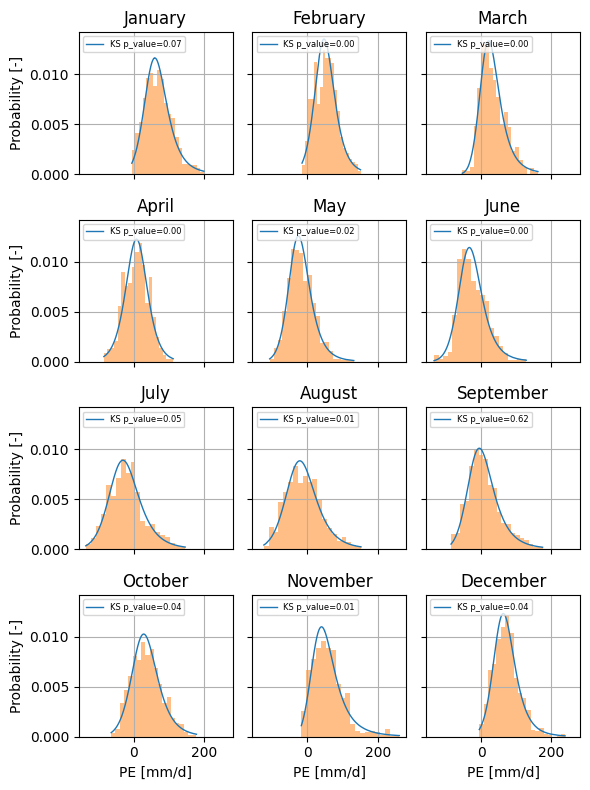

In [6]:
f, axl = plt.subplots(4, 3, figsize=(6, 8), sharey=True, sharex=True)
axsr = axl.ravel()
for date, dist in spei_fisk._dist_dict.items():
    pdf = dist.pdf()
    p_value = dist.ks_test()
    i = date.month - 1
    axsr[i].plot(
        dist.data.loc[pdf.index].values,
        pdf.values,
        color="C0",
        linewidth=1,
        label=f"KS {p_value=:0.2f}",
    )
    axsr[i].hist(
        dist.data.values,
        alpha=0.5,
        density=True,
        cumulative=False,
        bins=20,
        color="C1",
    )
    axsr[i].set_title(month_name[date.month])
    axsr[i].grid(True)
    axsr[i].legend(loc=2, fontsize=6)

[ax.set_ylabel("Probability [-]") for ax in axl[:, 0]]
[ax.set_xlabel("PE [mm/d]") for ax in axl[-1, :]]
f.tight_layout()

We can now see more cleary that there is a discrepancy between the data and the fitted distribution. However, the p_value is only less than 0.05 for march and august for the fisk distribution. For the log-logistic (fisk) this was also the case for june, october and november. So the fisk distribution seems better in for this precipitation excess series than the log-logistic (fisk) distribution.

## Window fitting

When the frequency of the original time series is higher than the fit frequncy, edge effects can occor. For instance if the frequency of the series is daily, but a distribution is fitted per month jumps can occur between the last and first day a new month. To prevent this the user can choose to fit a distribution on the frequency of the time series. However, fitting distributions per day gives less data per distribution to fit, sometimes resulting in a bad fit of the distribution. An example:

In [7]:
spi_d = si.spi(prec, dist=sps.fisk, fit_freq="D", prob_zero=False)

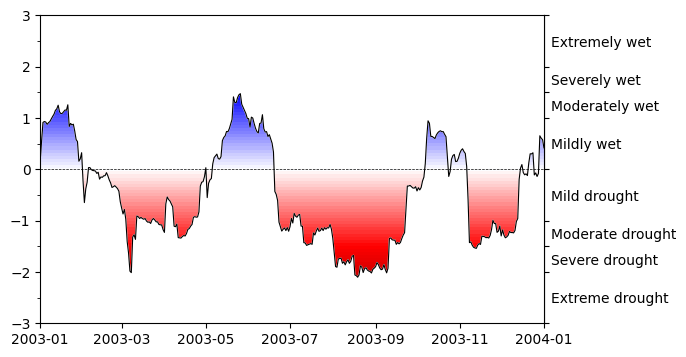

In [8]:
ax = si.plot.si(spi_d, ybound=3)
ax.set_xlim(pd.Timestamp("2003-01-01"), pd.Timestamp("2004-01-01"));

As can be seen in the figure sharp peaks are visible in the SPI, e.g. in march. To get a better fit of the distribution on those days, one can try to take into account days as well. After all, it is quite logical to take into account the distribution of the 1st of march and 3rd of march when determining the distribution for the 2nd of march. Note that this does not mean the distribution is summed over a larger window. Just more data is taken into account to determine the distribution for the specific day / week. The window argument provides for this:

In [9]:
spi_3d = si.spi(prec, dist=sps.fisk, fit_freq="D", fit_window=11, prob_zero=False)

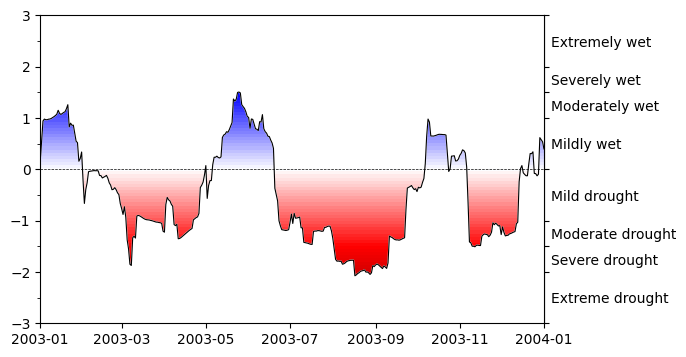

In [10]:
ax = si.plot.si(spi_3d, ybound=3)
ax.set_xlim(pd.Timestamp("2003-01-01"), pd.Timestamp("2004-01-01"));

As you can see the sudden peaks are a lot less sharp but some are still visible. Therefore it might be appropriate to choose a larger window. 

#### Flexible time scales and distribution fitting
Meteorological and hydrological time series are nowadays typically available at a daily frequency. To accommodate this, the `timescale` argument in the drought index function is designed to be flexible, with units that match the frequency of the input time series. For example, when using daily data, a `timescale` value of `30` corresponds approximately to a one-month drought index, `90` for three months, `180` for six months, and so on.

The frequency at which distributions are fitted (`fit_freq`) determines how many different distributions are fitted. With a daily fit frequency (`fit_freq="D"`), one distribution is fitted for every day of the year — 365 or 366 in total, depending on leap years. In contrast, a monthly fit (`fit_freq="MS"` or `"ME"`) fits a distribution for every month of the year; 12 in total. Although daily fitting is more computationally intensive, it can yield more precise results, as shown in later sections. Therefore, the number of data points available for each distribution fit depends on both `fit_freq`, the frequency, and the time length of the time series. For instance, with 30 years of monthly data and `fit_freq="MS"`, each monthly distribution is based on 30 data points. However, fitting a distribution to just 30 values can be challenging — especially for daily data, which is more prone to noise and outliers. By default, the package attempts to infer `fit_freq` based on the time series frequency. If inference fails, it defaults to a monthly fit. Users can also specify `fit_freq` manually for full control.

To improve fit stability, the `fit_window` argument allows users to include additional data points around each time step. The window size is specified in the same units as the fit frequency. For example for daily data and fit frequency, `fit_window=3` includes data from the day before and after a given date (e.g., March 14th–16th for March 15th) for the fitting of the distribution. A `fit_window=31` for daily data provides a sample size similar to monthly fitting, while retaining daily resolution. Though experimental, this fit window feature has shown to improve the robustness of daily fits. A fit window with an even number is automaticaly transformed to an odd number.

\autoref{fig:surplus_fit_window} illustrates the influence of different distribution fitting strategies — namely, `fit_freq` and `fit_window` on the calculation of the SPEI-1 index over the year 2001. The top row displays the cumulative distribution functions of precipitation surplus data for an excerpt of the time series of April (the 15th). \autoref{fig:surplus_fit_window}a shows the case where distributions are fitted daily (`fit_freq="D"`) without using a fitting window. Here, the fit is based solely on data from April 15th across 30 years, resulting in a limited sample size and consequently a noisier empirical distribution with a less stable fit. \autoref{fig:surplus_fit_window}b also uses a daily fitting frequency but applies a 31-day fitting window (`fit_window=31`) centered on April 15th. This expands the sample to include 31 days of data, significantly increasing the total number of observations and yielding a much smoother and more robust distribution fit. In contrast, \autoref{fig:surplus_fit_window}c shows a monthly fitting approach (`fit_freq="MS"`) with no fit window, where all April data from each year is used. This produces a stable fit, but because each month is treated separately, sharp transitions can occur at month boundaries, which may introduce artificial discontinuities into the resulting index. This is shown in the red line of \autoref{fig:surplus_fit_window}e, which is smoother overall but exhibits abrupt changes at the start of each month (e.g., April 1st and November 1st), due to transitions between monthly distributions. These settings allow users to tailor the standardization process to their data and desired level of temporal precision. \autoref{fig:surplus_fit_window}d shows the specific fisk distributions from each parameter set, shown in the text boxes of \autoref{fig:surplus_fit_window}a,b and c. The changes to the fitted parameter values are obvious, but the fitted distrubtions look similar as seen in \autoref{fig:surplus_fit_window}d. The result for the z-score is minimal on april 15th but larger for different dates as seen in \autoref{fig:surplus_fit_window}e.


In [11]:
timescale = 30

spei_d = si.SI(
    series=surplusd,
    dist=sps.fisk,
    timescale=timescale,
    fit_freq="D",
    fit_window=0,
)
spei_d.fit_distribution()

fit_window_dw = 31
spei_dw = si.SI(
    series=surplusd,
    dist=sps.fisk,
    timescale=timescale,
    fit_freq="D",
    fit_window=fit_window_dw,
)
spei_dw.fit_distribution()

spei_m = si.SI(
    series=surplusd, dist=sps.fisk, timescale=timescale, fit_freq="MS", fit_window=0
)
spei_m.fit_distribution()

speid = spei_d.norm_ppf()
speidw = spei_dw.norm_ppf()
speim = spei_m.norm_ppf()

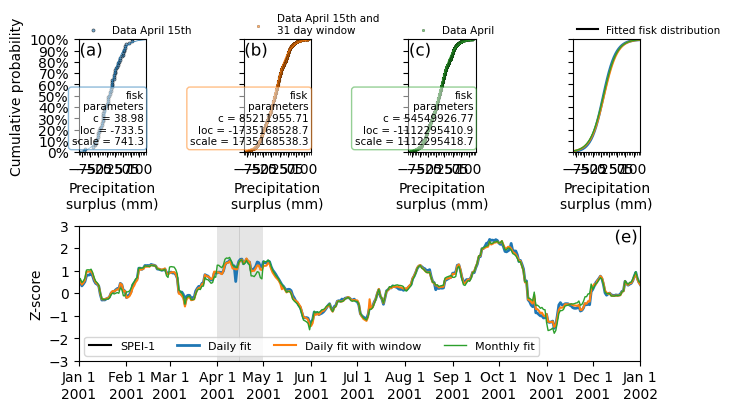

In [14]:
month = 4
ts_d = pd.Timestamp(f"2000-{month}-15")
ts_m = pd.Timestamp(f"2000-{month}-01")
dist_d = spei_d._dist_dict[ts_d]
dist_dw = spei_dw._dist_dict[ts_d]
dist_m = spei_m._dist_dict[ts_m]
data_d = dist_d.data.sort_values()
data_dw = dist_dw.data_window.sort_values()
data_m = dist_m.data.sort_values()
cdf_d = dist_d.cdf().loc[data_d.index]
cdf_dw = dist_dw.dist.cdf(data_dw.values, *dist_dw.pars, dist_dw.loc, dist_dw.scale)
cdf_m = dist_m.cdf().loc[data_m.index]
ecdf_d = sps.ecdf(data_d).cdf
ecdf_dw = sps.ecdf(data_dw).cdf
ecdf_m = sps.ecdf(data_m).cdf

fig, axd = plt.subplot_mosaic(
    [["d", "dw", "m", "cdf"], ["si", "si", "si", "si"]],
    layout="constrained",
    figsize=(7.0, 4.0),
    height_ratios=[1.0, 1.2],
)
scatter_kwargs = dict(
    alpha=0.6,
    zorder=2,
    edgecolors="k",
)
plot_ecdf(
    ax=axd["d"],
    data=data_d,
    ecdf=ecdf_d,
    color="C0",
    label=f"Data {ts_d.strftime('%B %d')}th",
    linewidths=0.5,
    s=5.0,
    **scatter_kwargs,
)
plot_ecdf(
    ax=axd["dw"],
    data=data_dw,
    ecdf=ecdf_dw,
    color="C1",
    label=f"Data {ts_d.strftime('%B %d')}th and\n{fit_window_dw} day window",
    linewidths=0.2,
    s=4.0,
    **scatter_kwargs,
)
plot_ecdf(
    ax=axd["m"],
    data=data_m,
    ecdf=ecdf_m,
    color="C2",
    label=f"Data {ts_m.strftime('%B')}",
    linewidths=0.2,
    s=4.0,
    **scatter_kwargs,
)
bin = 5.0
xmin = min(data_d.min(), data_dw.min(), data_m.min())
xmax = max(data_d.max(), data_dw.max(), data_m.max())
bins = np.arange(xmin // bin * bin, xmax + bin, bin)
axd["d"].set_xlim(xmin, xmax)
axd["d"].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(bin))
axd["d"].xaxis.set_major_locator(mpl.ticker.MultipleLocator(bin * 5))
axd["d"].set_ylim(0.0, 1.0)
axd["d"].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
axd["d"].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
for iax in [axd["dw"], axd["m"], axd["cdf"]]:
    iax.sharex(axd["d"])
    iax.sharey(axd["d"])
    for t in iax.get_yticklabels():
        t.set_visible(False)
axd["d"].set_ylabel("Cumulative probability")
axd["d"].set_xlabel("Precipitation\nsurplus (mm)")
axd["dw"].set_xlabel("Precipitation\nsurplus (mm)")
axd["m"].set_xlabel("Precipitation\nsurplus (mm)")
axd["cdf"].set_xlabel("Precipitation\nsurplus (mm)")

axd["d"].plot(
    bins,
    dist_d.dist.cdf(bins, *dist_d.pars, loc=dist_d.loc, scale=dist_d.scale),
    color="C0",
    linewidth=0.5,
)
axd["dw"].plot(
    bins,
    dist_dw.dist.cdf(bins, *dist_dw.pars, loc=dist_dw.loc, scale=dist_dw.scale),
    color="C1",
    linewidth=0.5,
)
axd["m"].plot(
    bins,
    dist_m.dist.cdf(bins, *dist_m.pars, loc=dist_m.loc, scale=dist_m.scale),
    color="C2",
    linewidth=0.5,
)
axd["cdf"].plot(
    [],
    [],
    color="k",
    linewidth=1.5,
    label=f"Fitted {dist_d.dist.name} distribution",
)
axd["cdf"].plot(
    bins,
    dist_d.dist.cdf(bins, *dist_d.pars, loc=dist_d.loc, scale=dist_d.scale),
    color="C0",
    linewidth=2.0,
)
axd["cdf"].plot(
    bins,
    dist_dw.dist.cdf(bins, *dist_dw.pars, loc=dist_dw.loc, scale=dist_dw.scale),
    color="C1",
    linewidth=1.5,
)
axd["cdf"].plot(
    bins,
    dist_m.dist.cdf(bins, *dist_m.pars, loc=dist_m.loc, scale=dist_m.scale),
    color="C2",
    linewidth=1.0,
)

mpl.rcParams["legend.fontsize"] = 8.0


def plot_box(ax: plt.Axes, dist: si.dist.Dist, bbox_edgecolor: str = "k") -> None:
    textstr = f"{dist.dist.name}\nparameters\n"
    textstr += f"c = {dist.pars[0]:0.2f}\n"
    textstr += f"loc = {dist.loc:0.1f}\n"
    textstr += f"scale = {dist.scale:0.1f}"
    ax.text(
        xmax - bin * 1.5,
        0.05,
        textstr,
        fontsize=mpl.rcParams["legend.fontsize"] - 0.5,
        horizontalalignment="right",
        verticalalignment="bottom",
        bbox=dict(
            boxstyle="round", facecolor="white", alpha=0.5, edgecolor=bbox_edgecolor
        ),
    )


plot_box(axd["d"], dist_d, bbox_edgecolor="C0")
plot_box(axd["dw"], dist_dw, bbox_edgecolor="C1")
plot_box(axd["m"], dist_m, bbox_edgecolor="C2")

axd["d"].legend(
    loc=(0, 1), frameon=False, fontsize=mpl.rcParams["legend.fontsize"] - 0.5
)
axd["dw"].legend(
    loc=(0, 1), frameon=False, fontsize=mpl.rcParams["legend.fontsize"] - 0.5
)
axd["m"].legend(
    loc=(0, 1), frameon=False, fontsize=mpl.rcParams["legend.fontsize"] - 0.5
)
axd["cdf"].legend(
    loc=(0, 1), frameon=False, fontsize=mpl.rcParams["legend.fontsize"] - 0.5
)

axd["si"].plot([], [], color="k", label="SPEI-1")
axd["si"].plot(
    speid.index,
    speid.values,
    linewidth=2.0,
    color="C0",
    label="Daily fit",
)
axd["si"].plot(
    speidw.index,
    speidw.values,
    linewidth=1.5,
    color="C1",
    label="Daily fit with window",
)
axd["si"].plot(
    speim.index,
    speim.values,
    linewidth=1.0,
    color="C2",
    label="Monthly fit",
)

year = 2001
axd["si"].fill_betweenx(
    [-3.0, 3.0],
    ts_m + pd.Timedelta(days=365),
    ts_m + pd.Timedelta(days=365 + 30),
    color="k",
    alpha=0.1,
    linewidth=0,
)
axd["si"].fill_betweenx(
    [-3.0, 3.0],
    ts_d + pd.Timedelta(days=365),
    ts_d + pd.Timedelta(days=365 + 1),
    color="k",
    alpha=0.1,
    linewidth=0,
)
axd["si"].set_xlim(pd.Timestamp(f"{year}"), pd.Timestamp(f"{year + 1}"))
axd["si"].xaxis.set_major_locator(mpl.dates.MonthLocator())
axd["si"].xaxis.set_major_formatter(mpl.dates.DateFormatter("%b%_d\n%Y"))
axd["si"].set_ylabel("Z-score")
axd["si"].grid(False)
axd["si"].legend(ncol=4, loc="lower left")
axd["si"].set_ylim(-3.0, 3.0)
axd["si"].yaxis.set_major_locator(mpl.ticker.MultipleLocator())

axes_indicator(axd["d"], "a", 0.01, 0.98, ha="left", va="top")
axes_indicator(axd["dw"], "b", 0.01, 0.98, ha="left", va="top")
axes_indicator(axd["m"], "c", 0.01, 0.98, ha="left", va="top")
axes_indicator(axd["si"], "e", 0.995, 0.98, ha="right", va="top")